# Reproducing Biomedical Image Segmentation in the U-Net paper

In this notebook we try to fully reproduce the method presented in the paper ["U-Net: Convolutional Networks for Biomedical Segmentation"](https://arxiv.org/pdf/1505.04597.pdf), particularly, the results presented in table 2 (DIC-C2DH-HeLa and PhC-C2DH-U373 datasets) and the pixel error of the U-Net reported in table 1 (ISBI2012 dataset).

The following implementation was carried out without using any pre-existing code.

## How does U-Net work ?

The U-Net is a convolutional network architecture for fast and precise segmentation of images. It learns segmentation in an end-to-end setting: a raw image is given in input and the output is the segmentation map.

<img src="images\Unet_intro.png" style="width:550;height:150px"/>

Convolutional network are typically used for classification tasks, so that the obtained output for an input image is a single class label. However, in the considered task of biomedical image segmentation, the desired output has to include localization, that means a class labels must be assigned to each pixel of the image.
To achieve this goal, the paper proposes the U-Net architecture: a contracting path used to capture context in the input image is supplemented with a symmetric expanding path that enables precise localization.

<img src="images\unet_architecture.png" style="width:700;height:300px"/>

As the previuos image shows, the input image is fed into the network, then the data are propagated into the network according to the displayed path and finally the segmentation map is given as output.
Each blue box corresponds to a multi-channel feature map: the x-y size is reported on the edge, while the number of channel is denoted on top of the box.
The contracting path mimics the classical architecture of a convolutional network with the repeated application of two 3x3 unpadded convolutions each followed by a ReLU and a 2x2 max pooling operation with stride 2.
In the expanding path, the pooling operators are replaced by upsampling operators, 2x2 convolution, that increase the resolution of the output. To achieve localization, high resolution cropped features map from the contracting path are combined with the upsampled output using a concatenation, represented by the grey arrows.
Finally the last layer applies a 1x1 convolution to obtain the output segmentation map with two channels: one for the foreground class and the other for the background one.


The challenges the paper deals with are the availability of few annotated images, componing the dataset, and the presence of touching objects of the same class that need to be separated by the segmentation algorithm.

The presented training strategy relies indeed on strong use of data augmentation.

Moreover, to achieve a correct separation of touching objects of the same class, the authors insert an artificial one pixel wide background ridge between touching instances in the ground truth segmentation mask. Moreover to force the network to learn these artificial ridges, their weight in the loss computation is increased, so that the thinnest ridges have the highest weights. This is accomplished thanks to a properly defined weight map that will be detailed later in this notebook.

The paper shows that the described network is fast and can be trained end-to-end from a very few images, outperforming the prior best method on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. 

## Experiment Setup

The authors apply the U-Net to three different segmentation tasks.

The first task is the segmentation of neuronal structures in electron microscopic recordings, using the data provided by the EM segmentation challenge (ISBI2012 dataset), obtaining the best score in terms of warping error (March 2015). The main challenges in this dataset are represented by structure with very low contrast, fuzzy membranes and other cell compartments.
Here is an example of image taken by this dataset:

<img src="images\isbi_example.png" style="width:150;height:150px"/>

Ranking on the EM segmentation challenge (march 6th, 2015), sorted by warping error:

<img src="images\Table1.png" style="width:350;height:150px"/>

The network is also applied to cell segmentation task in light microscopic images that is part of the ISBI cell tracking challenge2015. 
The first data set "PhC-U373" contains cells recorded by phase contrast microscopy and they show strong shape variation, weak outer borders and strong irrelevant inner borders and the cytoplasm has the same structure like the background. The authors state they obtain a value of 92% IoU (intersection over union) outperforming the second best algorithm with 83%.
An images taken by this dateset is the following:

<img src="images\Phc_example.png" style="width:150;height:100px"/>

The second data set "DIC-HeLa" contains cells on a flat glass recorded by differential interference contrast microscopy: this is one of the most challenging dataset because it contains touching and overlapping cells and partially invisible borders.
Do you want an example? Here you are:

<img src="images\Hela_example.png" style="width:150;height:150px"/>

On this last dataset, according to the paper, the network achieves an average IoU of 77.5% that is significantly better than the score of 46%, obtained with the second best algorithm.

Segmentation results(IoU) on the ISBI cell tracking challenge 2015:

<img src="images\Table2.png" style="width:325;height:125px"/>

In the remaining part of the notebook, we try to fully reproduce the results presented in table 2 and the pixel error of the U-Net reported in table 1, without using the pre-existing code, made available by the authors.

## Our implementation

To run this notebook, we use a server in Google Cloud Platform (GPC) with a Tesla P100 16GB GPU.


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas

import numpy as np
import cv2 as cv
import os
import shutil
from batchgenerators.utilities.file_and_folder_operations import maybe_mkdir_p

from torchvision.utils import save_image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from data import download_all_data, preprocess_gt, ImageDataset, ImageDataset_test, download_all_models
from network import Unet
from functions import weighted_map, class_balance, input_size_compute, evaluation_metrics

from time import time

CUR_DIR = os.path.abspath('')

## Dataset

The following part of the notebook downloads all datasets used in the paper. Then the crop dimension is selected according to the dimensions of the images present is the dataset chosen by the user. By default we work with 388*388 patches.

Moreover, as mentioned in the previous section, for the 'DIC-C2DH-HeLa' dataset, one of the main challenges is the presence of objects of the same class overlapping. Semantic segmentation indeed classifies pixels of an images, therefore touching objects of the same class will end up in one joint segment. To face this problem, our routine "preprocess_gt" is called: it highlights object (cell) edges and scales the ground truth from [0,num_objects] to [0, 255], setting background at 0 and all object at 255. It outputs the scaled ground truth with the artificial one pixel wide background ridge between touching instances.

Finally contrast is maximized for the groud truth and the pixel wise weight loss is computed and shown for viewing purposes.

This last operation is achieved thanks to the "weighted_map" function that highlight the borders between different objects (cells). We further review this function later in this study.

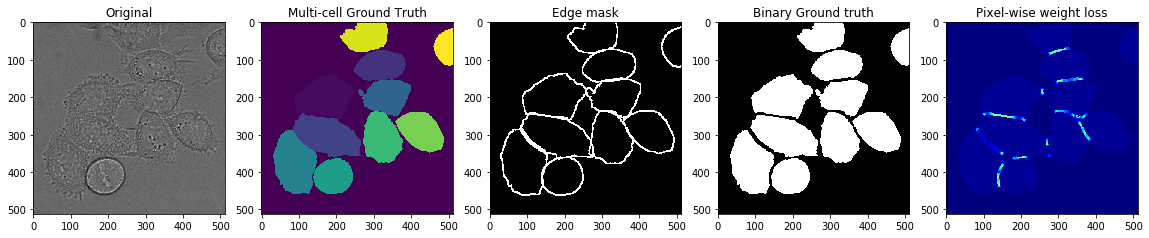

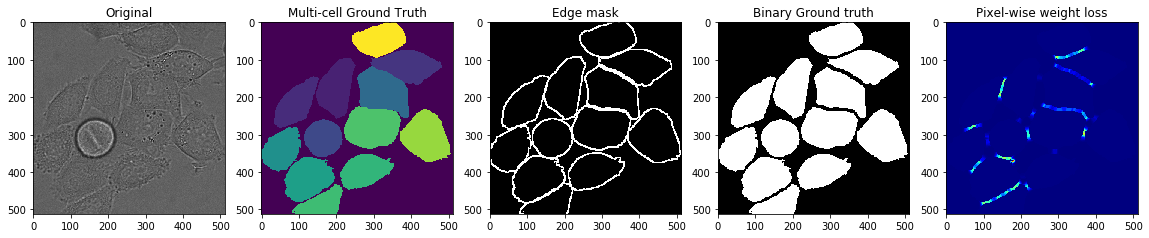

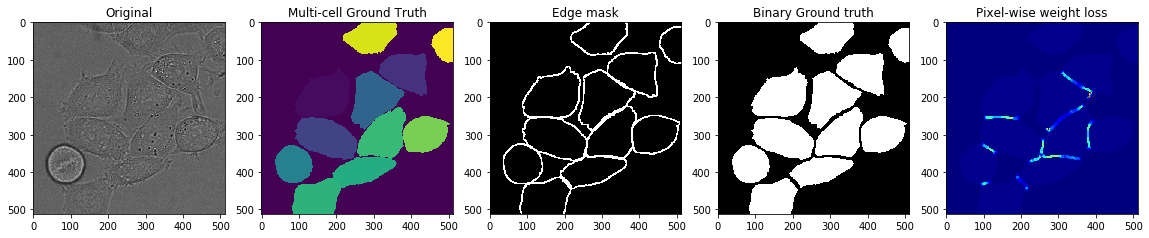

In [2]:
# Download data
download_all_data()
download_all_models()

# Specify which dataset to analyse

# DATASET = 'PhC-C2DH-U373' # [520, 696]
# DATASET = 'ISBI2012'
DATASET = 'DIC-C2DH-HeLa'

ISBI2012 = False

crop = 388

training_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01")

if DATASET == 'ISBI2012':
    ISBI2012 = True
    target_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_GT", "SEG")
    target = os.listdir(target_path)    
else:
    target_GT_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_GT", "SEG")
    target_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_ST", "SEG")
    target_GT = os.listdir(target_GT_path)
    for image in target_GT:
        os.remove(os.path.join(target_path, image)) 
    target = os.listdir(target_path)    
    for image in target_GT:
        shutil.copyfile(os.path.join(target_GT_path, image), os.path.join(target_path, image))

for i in range(3):
    # load images
    img_training = cv.imread(os.path.join(training_path, f"t{target[i][7:]}"), -1)
    img_gt = cv.imread(os.path.join(target_path, target[i]), -1)
    
    # image morphology, for edge detection (ONLY FOR DIC-C2DH-HeLa, since cells intersect)
    gt, mask_global = preprocess_gt(img_gt)
    if DATASET != "DIC-C2DH-HeLa":
        gt = img_gt
    
    fig = plt.figure(figsize=(16,9))
    plt.subplot(1,5,1)
    plt.imshow(img_training, cmap='gray')
    plt.title("Original")
    plt.subplot(1,5,2)
    plt.imshow(img_gt)
    plt.title('Multi-cell Ground Truth')
    plt.subplot(1,5,3)
    plt.title('Edge mask')
    plt.imshow(mask_global > 0, cmap='gray')  # binary of cell edges
    plt.subplot(1,5,4)

    _, gt_bin = cv.threshold(gt, 0, 255, cv.THRESH_BINARY)
    plt.imshow(torch.from_numpy(gt_bin.astype('uint8')), cmap='gray')
    plt.title('Binary Ground truth')
    
    # Calculating loss for ground truth
    loss_img = weighted_map(torch.from_numpy(gt_bin.reshape((1,1,img_training.shape[0],img_training.shape[1])).astype('float32')) / 255).numpy().reshape((img_training.shape[0],img_training.shape[1]))
    plt.subplot(1,5,5)
    plt.imshow(loss_img, cmap='jet')
    plt.title("Pixel-wise weight loss")
    plt.tight_layout()
    plt.show()

## Data Augmentation

One of the main challenge in biomedical image segmentation is to deal with the low amount of training data. Data augmentation is indeed required and, in this paper particularly, random elastic deformation is used: this allows the network to learn invariance to such deformation and, moreover, it is important in the considered framework due to the fact deformation is used to be the most common variation in tissue.

Data augmentation is performed by the following (adapted) piece of code. An object is initialized thanks to the method "init()" of our class "ImageDataset" that takes among its arguments some parameters needed to perform the elastic deformation. Due to the fact the authors don't specify the value for "alpha" in the paper and they didn't reply to our mail where we ask for it, we choose "alpha"=200.

The first operation is to crop a 388*388 patch at a random location of the image.

Then we mirror the input image and label (in the case of training) to generate images such that network's output size is greater or equal than the label's original size, extrapolating the missing context.

After that we augment the dataset applying first a random rotation, allowing possible rotations to every 30º.

Then we perform an elastic deformation using displacement vectors. According to what state in the paper, the displacement are sampled from a Gaussian distribution with 10 pixels standard deviation (sigma=10). These displacement vectors are used to generate a dense deformation fields using bicubic interpolation.

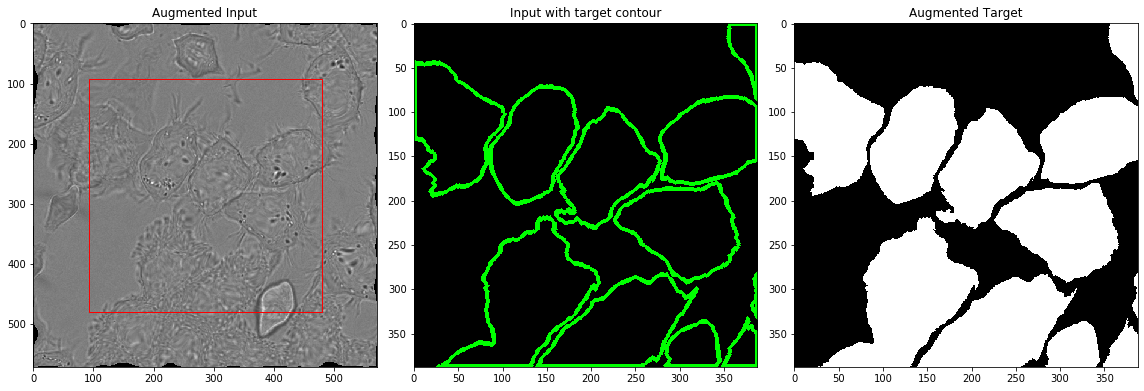

In [3]:
root_dir = os.path.join(CUR_DIR, "data", f"{DATASET}-training")
data = ImageDataset(root_dir, alpha=200, sigma=10, crop=crop, ISBI2012=ISBI2012)   # For training + validation

orig_img = cv.imread(os.path.join(root_dir, '01', os.listdir(os.path.join(root_dir, "01"))[0]), -1)

img, gt = data[0]

original_size, input_size, _ = input_size_compute(gt)
pad = int((input_size - original_size) / 2)

fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

rect = patches.Rectangle((pad,pad),original_size,original_size,linewidth=1,edgecolor='r',facecolor='none')
gt = gt.reshape(gt.shape[1:]).numpy().astype(np.uint8)
contours, hierarchy = cv.findContours(gt, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
image = cv.cvtColor(img.reshape(img.shape[1:])[pad:pad+original_size,pad:pad+original_size].numpy().astype(np.uint8),cv.COLOR_GRAY2RGB)
cv.drawContours(image, contours, -1, (0, 255, 0), 3)

ax0.imshow(img.reshape(img.shape[1:]), cmap='gray')
ax0.add_patch(rect)
ax0.set_title('Augmented Input')
ax1.imshow(image)
ax1.set_title('Input with target contour')
ax2.imshow(gt, cmap='gray')
ax2.set_title('Augmented Target')

fig.tight_layout()
plt.show()

## Training

Based on what is said in the paper, the network is trained using stochastic gradient descendent (SGD) with high momentum (0.99) as optimizer. The training is set to stop once the learning rate drops below 1e-6 and the validation loss does not improve in a number of epochs set by the patience, or alternatively 500 epochs are reached (in practice it is always the former). The number of epochs is set to 2 in this dummy example below.

We perform a cross validation procedure, according to the user defined parameter "val_per" and "tr_per" that define the size of the validation and training set. The creation of these two sets is then carried out thanks to a shuffle procedure applied to the images collected in a vector (following a random seed that can be specified when running the main_main.py script). By default, we use a 80:20 ratio for training:validation.

To force the network to learn the artificial one pixel wide background ridge between touching instances we inserted to solve the problem of overlapping objects, the authors of the paper use a weight map that increase the weight of the ridge pixels so that the thinnest ridges get the highest weights. The weight map used is:

<img src="images\weight_map.png" style="width:125;height:75px"/>

where $w_c$ is the pre-computed weight map for each ground truth segmentation to balance class frequencies. The second term approximate the ridge width at each pixel by the sum of the distance $d_1$ to its nearest instance and the distance $d_2$ to its second nearest istance. According to what is stated in the paper, $\sigma=5$ and $w_0=10$. We have also tried higher $w_0=20$ with the aim to further highlight cell borders and narrow background regions.

The authors state that the energy function is computed by a pixel-wise soft-max over the final feature map combined with the cross entropy loss function. For training, indeed, the final 2-class scores are transformed to probabilities with softmax before they are compared to the ground truth annotations using weighted cross entropy. We use a binary cross entropy with logits (BCEWithLogitsLoss) as criterion for training using as weight the previously defined weight map. Note that this criterion uses a softmax activation function internally.

The paper doesn't mention any information about the learning rate: in our implementation we decide to use a learning rate scheduler starting from 1e-4 and dropping by a factor of 0.1 once the validation loss does not improve after 20 consecutive epochs (patience). An improvement is considered when the validation loss is at least a 0.1% smaller than the best epoch (defined by the parameter eps). In some instances, we have varied the patience and the eps value to adapt it better to the behavior of the validation loss, making the learning rate changes a bit more flexible. As we have mentioned, training generally stops when the learning rate reaches a value below 1e-6 and validation loss does not improve in [patience] epochs. In practice, we find that when the learning rate reaches this mark, the model is already overfitting.

It is also important to recall that the weights have to be correctly initialized: this is done together with the definition of the U-Net and following the criteria provided by the authors. Accordingly, the weights should be initialized following a gaussian distribution of mean 0 and standard deviation of $\sqrt(2 / N)$ with $N$ being the number of incoming nodes of one neuron.

From each training, we save the best model (the one with the minimum validation loss) as well as the last epoch of the training. We also save the model every 25 epochs regardless, in case we stop the training early.

In [4]:
# Parameters:
val_per = 0.2
tr_per  = 1.0 - val_per
batch_size = 1
epochs = 2

In [5]:
root_dir = os.path.join(CUR_DIR, "data", f"{DATASET}-training")
train_dataset = ImageDataset(root_dir, alpha=200, sigma=10, ISBI2012=ISBI2012)   # For training + validation

samp_tr  = int(np.round(tr_per  * len(train_dataset)))
samp_val = int(np.round(val_per * len(train_dataset)))

# We round numbers so that we do not exceed total number of samples
while samp_tr + samp_val > len(train_dataset):
    samp_val += -1

# We generate an order vector to shuffle the samples before each fold for the cross validation  
order = np.arange(len(train_dataset))
np.random.shuffle(order)

# Suffle the training set
train_dataset = [train_dataset[idx] for idx in order]

# Divide between training and validation sets by order (in notebook we only use a few images for speed purposes)
train_set = train_dataset[0:2]
val_set   = train_dataset[2:3]

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=True)

# Shift values in order for next fold of cross validation (a shift of samp_val)
order = np.append(order[samp_val:], order[0:samp_val])
        
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')

else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the CPU


In [6]:
# To be called as: training(unet, train_loader, val_loader, epochs, batch_size, device, fold_dir):

train_dir = os.path.join(CUR_DIR, 'nb_train')
maybe_mkdir_p(train_dir)

torch.cuda.empty_cache()
unet = Unet().to(device)

optimizer = optim.SGD(unet.parameters(), lr=0.001, momentum=0.99)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, threshold=1e-2, threshold_mode='rel', eps=1e-7)
my_patience = 0

maybe_mkdir_p(os.path.join(train_dir, 'progress'))
maybe_mkdir_p(os.path.join(train_dir, 'models' ))

loss_best_epoch = 100000.0

for epoch in range(epochs+1):
    
    print(' ')
    print('Epoch:', epoch)

    start = time()
    total_loss = 0
    total_loss_val = 0
    start_eval_train = 0
    start_eval_val = 0

    for batch in train_loader:

        optimizer.zero_grad()

        images, labels = batch
        preds = unet(images.to(device)) # pass batch to the unet

        pad = int((preds.shape[-1] - labels.shape[-1]) / 2)
        preds = preds[:, :, pad:labels.shape[-1]+pad, pad:labels.shape[-1]+pad]

        ll = torch.empty_like(preds)
        ll[:,0,:,:] = 1 - labels[:, 0, :, :]  # background
        ll[:,1,:,:] = labels[:, 0, :, :]  # cell
        ll = ll.to(device)

        if DATASET is 'DIC-C2DH-HeLa':
            weight_maps = weighted_map(labels.squeeze(1)).to(device)
            criterion = nn.BCEWithLogitsLoss(weight=weight_maps)
        else:
            weight_maps = class_balance(labels.squeeze(1)).to(device)
            criterion = nn.BCEWithLogitsLoss(weight=weight_maps)

        loss = criterion(preds, ll)

        loss.backward() # compute the gradients using backprop
        optimizer.step() # update the weights

        total_loss += loss

        preds = preds.argmax(dim=1)

        for idx in range(preds.shape[0]):
            if start_eval_train == 0 and idx == 0: # First time in epoch we initialize train_eval
                train_eval = evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())
                start_eval_train += 1
            else:
                np.concatenate((train_eval, evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())), axis=1)

    train_eval_epoch = np.mean(train_eval, axis=1)

    with torch.no_grad():
        for batch in val_loader:
            
            images, labels = batch
            preds = unet(images.to(device))

            pad = int((preds.shape[-1] - labels.shape[-1]) / 2)
            preds = preds[:, :, pad:labels.shape[-1]+pad, pad:labels.shape[-1]+pad]

            ll = torch.empty_like(preds)
            ll[:,0,:,:] = 1 - labels[:, 0, :, :] # background
            ll[:,1,:,:] = labels[:, 0, :, :] # cell
            ll = ll.to(device)

            if DATASET is 'DIC-C2DH-HeLa':
                weight_maps = weighted_map(labels.squeeze(1)).to(device)
                criterion = nn.BCEWithLogitsLoss(weight=weight_maps)
            else:
                weight_maps = class_balance(labels.squeeze(1)).to(device)
                criterion = nn.BCEWithLogitsLoss(weight=weight_maps)

            loss = criterion(preds, ll)

            total_loss_val += loss

            preds = preds.argmax(1)

            for idx in range(preds.shape[0]):
                if start_eval_val == 0 and idx == 0: # First time in epoch we initialize val_eval
                    val_eval = evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())
                    start_eval_val += 1
                else:
                    np.concatenate((val_eval, evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())), axis=1)

    val_eval_epoch = np.mean(val_eval, axis=1)

    scheduler.step(total_loss_val / (len(val_loader) * batch_size)) # update the lr

    for param_group in optimizer.param_groups: l_rate = param_group['lr']

    loss_epoch     = total_loss / (len(train_loader) * batch_size)
    loss_epoch_val = total_loss_val / (len(val_loader) * batch_size)

    if loss_epoch_val < (loss_best_epoch * (1.0 - scheduler.threshold)):
        loss_best_epoch = loss_epoch_val
        print('New best epoch!')
        my_patience = 0
        PATH = os.path.join(train_dir, 'models', 'unet_weight_save_best.pth')
        torch.save(unet.state_dict(), PATH)
        print('Model has been saved:')
        print(PATH)
    else:
        my_patience += 1

    print('Current lr is:             ', l_rate                                      )
    print('Patience is:                {}/{}'.format(my_patience, scheduler.patience))
    print('Mean IoU training:         ', "{:.6f}".format(train_eval_epoch[0])        )
    print('Mean PE training:          ', "{:.6f}".format(train_eval_epoch[1])        )
    print('Mean IoU validation:       ', "{:.6f}".format(val_eval_epoch[0])          )
    print('Mean PE validation:        ', "{:.6f}".format(val_eval_epoch[1])          )
    print('Total training loss:       ', "{:.6f}".format(loss_epoch.item())          )
    print('Total validation loss:     ', "{:.6f}".format(loss_epoch_val.item())      )
    print('Best epoch validation loss:', "{:.6f}".format(loss_best_epoch.item())     )
    print('Epoch duration:            ', "{:.6f}".format(time()-start), 's'          )
    print('                                                                         ')

    # Save progress (evaluation metrics and loss)
    if epoch == 0:
        train_eval_progress_iou = [train_eval_epoch[0]]
        train_eval_progress_pe  = [train_eval_epoch[1]]
        val_eval_progress_iou   = [val_eval_epoch[0]]
        val_eval_progress_pe    = [val_eval_epoch[1]]
        loss_progress           = [loss_epoch.item()]
        loss_progress_val       = [loss_epoch_val.item()]
    elif epoch > 0:
        train_eval_progress_iou = np.concatenate((train_eval_progress_iou, [train_eval_epoch[0]]))
        train_eval_progress_pe  = np.concatenate((train_eval_progress_pe, [train_eval_epoch[1]]) )
        val_eval_progress_iou   = np.concatenate((val_eval_progress_iou, [val_eval_epoch[0]])    )
        val_eval_progress_pe    = np.concatenate((val_eval_progress_pe, [val_eval_epoch[1]])     )
        loss_progress           = np.append(loss_progress, [loss_epoch.item()]                   )
        loss_progress_val       = np.append(loss_progress_val, [loss_epoch_val.item()]           )

    np.savetxt(os.path.join(train_dir, 'train_eval_iou.out'), train_eval_progress_iou)
    np.savetxt(os.path.join(train_dir, 'train_eval_pe.out' ), train_eval_progress_pe )
    np.savetxt(os.path.join(train_dir, 'val_eval_iou.out'  ), val_eval_progress_iou  )
    np.savetxt(os.path.join(train_dir, 'val_eval_pe.out'   ), val_eval_progress_pe   )
    np.savetxt(os.path.join(train_dir, 'loss.out'          ), loss_progress          )
    np.savetxt(os.path.join(train_dir, 'loss_val.out'      ), loss_progress_val      )

    if l_rate < 10 * scheduler.eps and my_patience == scheduler.patience:
        print(f'LR dropped below {10 * scheduler.eps}!')
        print('Stopping training')
        break

    if my_patience == scheduler.patience: my_patience = 0

print('Training is finished as epoch {} has been reached'.format(epochs))


Epoch: 0
New best epoch!
Model has been saved:
/Users/pere/opt/anaconda3/envs/DL_Delft/DL-unet/nb_train/models/unet_weight_save_best.pth
Current lr is:              0.001
Patience is:                0/20
Mean IoU training:          0.031352
Mean PE training:           0.602548
Mean IoU validation:        0.472002
Mean PE validation:         0.527998
Total training loss:        32.648300
Total validation loss:      6.323137
Best epoch validation loss: 6.323137
Epoch duration:             33.860605 s
                                                                         
 
Epoch: 1
New best epoch!
Model has been saved:
/Users/pere/opt/anaconda3/envs/DL_Delft/DL-unet/nb_train/models/unet_weight_save_best.pth
Current lr is:              0.001
Patience is:                0/20
Mean IoU training:          0.609755
Mean PE training:           0.390245
Mean IoU validation:        0.472002
Mean PE validation:         0.527998
Total training loss:        7.539870
Total validation loss:      2.

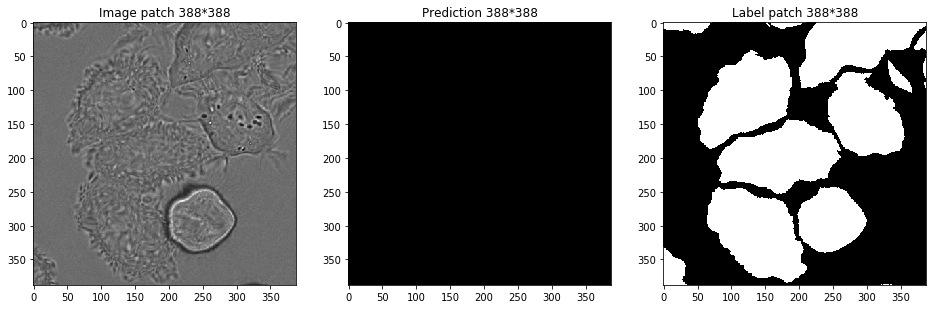

In [7]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    original_size, input_size, _ = input_size_compute(gt)
    pad = int((input_size - original_size) / 2)

    ax0.imshow(images[0, 0, pad:original_size+pad, pad:original_size+pad].detach(), cmap='gray')
    ax1.imshow(preds[0, :, :].detach(), cmap='gray')
    ax2.imshow(labels[0, 0, :, :].detach(), cmap='gray')

    ax0.set_title('Image patch 388*388')
    ax1.set_title('Prediction 388*388')
    ax2.set_title('Label patch 388*388')

## Weight Map

In this part of the code we want to show the effect of the weight map used to force the network to learn the artificial ridges inserted: their weight in the loss computation is increased, so that the thinnest ridges have the highest weights.

As said, this is accomplished thanks to a properly defined weight map and its effect on the loss weight for each pixel is shown in the result of the following lines of code. This weight computation is only used in the case of the 'DIC-C2DH-HeLa' dataset. In the case of the other datasets, we only apply a class balancing for the weight computation, accounting for the difference in class frequencies.

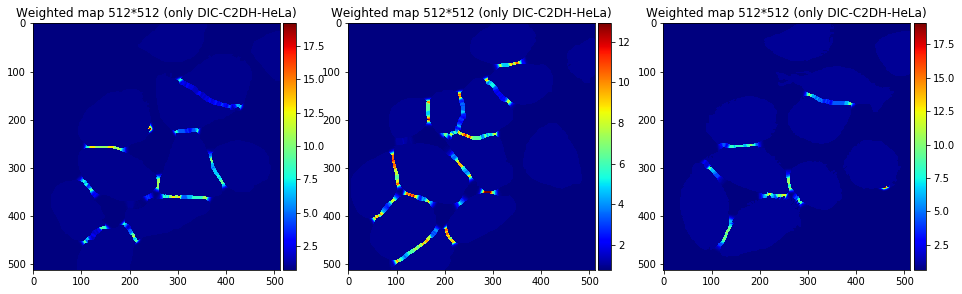

In [8]:
path_labels = os.path.join(CUR_DIR, 'models/DIC-C2DH-HeLa/random_cropping_388/fold0/models/unet_weight_save_best_test/labels')

for i in range(1):
    label_weight0 = torch.tensor(cv.imread(os.path.join(path_labels, 'label0.tif'),  cv.IMREAD_GRAYSCALE).reshape([1, 512, 512])).float() / 255
    w0 = weighted_map(label_weight0)
    label_weight1 = torch.tensor(cv.imread(os.path.join(path_labels, 'label3.tif'),  cv.IMREAD_GRAYSCALE).reshape([1, 512, 512])).float() / 255
    w1 = weighted_map(label_weight1)
    label_weight2 = torch.tensor(cv.imread(os.path.join(path_labels, 'label6.tif'), cv.IMREAD_GRAYSCALE).reshape([1, 512, 512])).float() / 255
    w2 = weighted_map(label_weight2)

    fig = plt.figure(figsize=(16,9))

    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    im0 = ax0.imshow(w0[0, :, :].detach(), cmap='jet')
    ax0.set_title('Weighted map 512*512 (only DIC-C2DH-HeLa)')
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im0, cax=cax)

    im1 = ax1.imshow(w1[0, :, :].detach(), cmap='jet')
    ax1.set_title('Weighted map 512*512 (only DIC-C2DH-HeLa)')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax)

    im2 = ax2.imshow(w2[0, :, :].detach(), cmap='jet')
    ax2.set_title('Weighted map 512*512 (only DIC-C2DH-HeLa)')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)

## Training progress & overfitting

In this section, we show what are the evolution of the training loss and the validation loss plotted in function of the number of epochs. The comparison between the two curves allows to understand where the model starts overfitting: we can identify this phenomenum when the validation loss begin to grow, while the training loss continues to decrease.

We also plot an evaluation metric (the intersection over union (IoU)) for the DIC-C2DH-HeLa and the ISBI2012 datasets.

Looking at the next figures, one can notice that overfitting is evident for HeLa and ISBI2012 datasets, while for the PhC dataset this is not as clear, although we already see a slight stabilization of both losses at different values, with the validation loss acquiring a slightly bigger value.

A more adapted learning rate scheduler for each dataset or the implementation of the exponentially-weighted moving average for the validation loss could improve the results that we obtain with the current state of the network.

As we commented in the training section, the model we save and use at the end of the training phase is the one that achives the smallest validation loss.

### DIC-C2DH-HeLa

In [9]:
progress_HeLa = f'models/DIC-C2DH-HeLa/random_cropping_388/fold0/progress'

In [10]:
train_loss_HeLa = np.loadtxt(os.path.join(progress_HeLa, 'loss.out'))
val_loss_HeLa   = np.loadtxt(os.path.join(progress_HeLa, 'loss_val.out'))
train_iou_HeLa  = np.loadtxt(os.path.join(progress_HeLa, 'train_eval_iou.out'))
val_iou_HeLa    = np.loadtxt(os.path.join(progress_HeLa, 'val_eval_iou.out'))
train_pe_HeLa   = np.loadtxt(os.path.join(progress_HeLa, 'train_eval_pe.out'))
val_pe_HeLa     = np.loadtxt(os.path.join(progress_HeLa, 'val_eval_pe.out'))

epoch_vec_HeLa = np.arange(len(train_loss_HeLa))

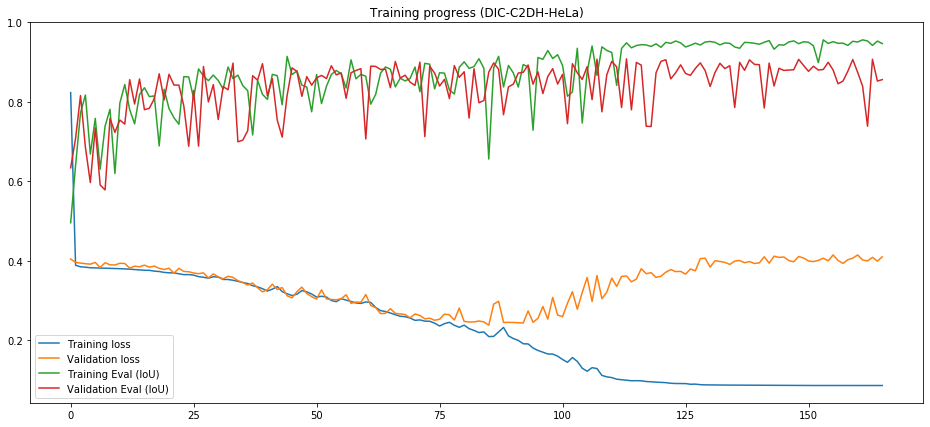

In [11]:
for i in range(1):
    fig = plt.figure(figsize=(16,7))
    ax0 = fig.add_subplot(111)

    ax0.plot(epoch_vec_HeLa, train_loss_HeLa, label='Training loss')
    ax0.plot(epoch_vec_HeLa, val_loss_HeLa,   label='Validation loss')
    ax0.plot(epoch_vec_HeLa, train_iou_HeLa,  label='Training Eval (IoU)')
    ax0.plot(epoch_vec_HeLa, val_iou_HeLa,    label='Validation Eval (IoU)')

    ax0.set_title('Training progress (DIC-C2DH-HeLa)')
    ax0.legend()
    ax0.set_ylim(ymax=1)

### ISBI2012

In [12]:
progress_ISBI = f'models/ISBI2012/rotation_388/fold0/progress'

In [13]:
train_loss_ISBI = np.loadtxt(os.path.join(progress_ISBI, 'loss.out'))
val_loss_ISBI   = np.loadtxt(os.path.join(progress_ISBI, 'loss_val.out'))
train_iou_ISBI  = np.loadtxt(os.path.join(progress_ISBI, 'train_eval_iou.out'))
val_iou_ISBI    = np.loadtxt(os.path.join(progress_ISBI, 'val_eval_iou.out'))
train_pe_ISBI   = np.loadtxt(os.path.join(progress_ISBI, 'train_eval_pe.out'))
val_pe_ISBI     = np.loadtxt(os.path.join(progress_ISBI, 'val_eval_pe.out'))

epoch_vec_ISBI = np.arange(len(train_loss_ISBI))

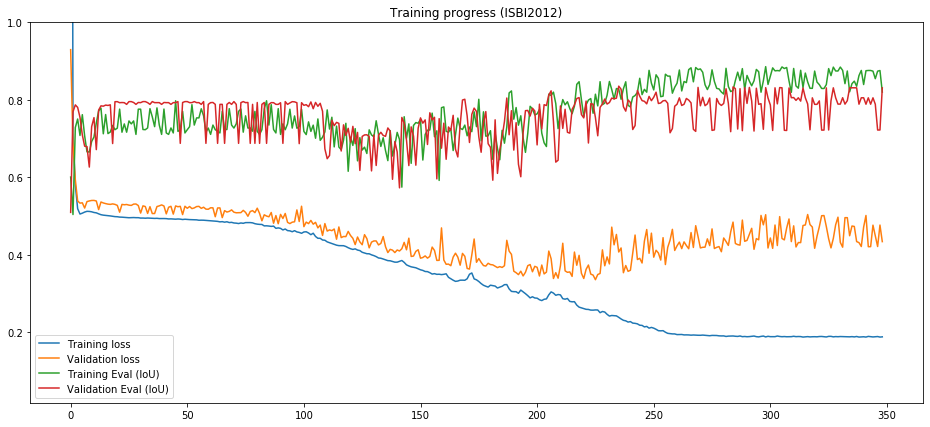

In [14]:
for i in range(1):
    fig = plt.figure(figsize=(16,7))
    ax0 = fig.add_subplot(111)

    ax0.plot(epoch_vec_ISBI, train_loss_ISBI, label='Training loss')
    ax0.plot(epoch_vec_ISBI, val_loss_ISBI,   label='Validation loss')
    ax0.plot(epoch_vec_ISBI, train_iou_ISBI,  label='Training Eval (IoU)')
    ax0.plot(epoch_vec_ISBI, val_iou_ISBI,    label='Validation Eval (IoU)')

    ax0.set_title('Training progress (ISBI2012)')
    ax0.legend()
    ax0.set_ylim(ymax=1)

### PhC-C2DH-U373

In [15]:
progress_PhC = f'models/PhC-C2DH-U373/rotation_388/fold1/progress'

In [16]:
train_loss_PhC = np.loadtxt(os.path.join(progress_PhC, 'loss.out'))
val_loss_PhC   = np.loadtxt(os.path.join(progress_PhC, 'loss_val.out'))
train_iou_PhC  = np.loadtxt(os.path.join(progress_PhC, 'train_eval_iou.out'))
val_iou_PhC    = np.loadtxt(os.path.join(progress_PhC, 'val_eval_iou.out'))
train_pe_PhC   = np.loadtxt(os.path.join(progress_PhC, 'train_eval_pe.out'))
val_pe_PhC     = np.loadtxt(os.path.join(progress_PhC, 'val_eval_pe.out'))

epoch_vec_PhC = np.arange(len(train_loss_PhC))

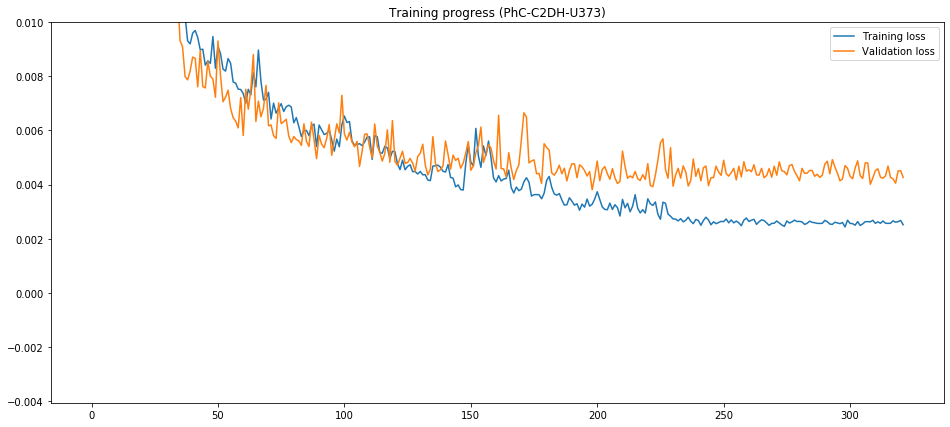

In [17]:
for i in range(1):
    fig = plt.figure(figsize=(16,7))
    ax0 = fig.add_subplot(111)

    ax0.plot(epoch_vec_PhC, train_loss_PhC, label='Training loss')
    ax0.plot(epoch_vec_PhC, val_loss_PhC,   label='Validation loss')

    ax0.set_title('Training progress (PhC-C2DH-U373)')
    ax0.legend()
    ax0.set_ylim(ymax=0.01)

## Testing

For testing images the only operation applied is mirroring to obtain the right dimension of the input that generates an output at least of the same size as the label. We compute The intersection over union (IoU) and the pixel error (PE).

In [18]:
DATASET = 'DIC-C2DH-HeLa'
NETWORK = f'models/{DATASET}/random_cropping_388/fold0/models/unet_weight_save_best.pth'

In [19]:
DATASET = 'ISBI2012'
NETWORK = f'models/{DATASET}/rotation_388/fold0/models/unet_weight_save_best.pth'

In [20]:
DATASET = 'PhC-C2DH-U373'
NETWORK = f'models/{DATASET}/rotation_388/fold0/models/unet_weight_save_best.pth'

In [21]:
model_path = os.path.join(CUR_DIR, NETWORK)
root_dir = os.path.join(CUR_DIR, "data", f"{DATASET}-training")

In [22]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

# Get test data
test_dataset  = ImageDataset_test(root_dir, ISBI2012=False)   
test_dataset  = [test_dataset[idx] for idx in range(len(test_dataset))]
test_set      = test_dataset         
test_loader   = DataLoader(test_set, batch_size=1, shuffle=False)

# Make directory for test outputs (assumes .pth format)
output_dir = model_path[0:len(model_path)-4] + '_test'
maybe_mkdir_p(output_dir)

torch.cuda.empty_cache()
unet = Unet().to(device)
unet.load_state_dict(torch.load(model_path, map_location=device))

Running on the CPU


<All keys matched successfully>

In [23]:
# To be called as: testing(unet, test_loader, batch_size, device, output_dir)

print('Working on the {} dataset.'.format(DATASET))
print(' ')

start = time()
start_eval_test = 0
idx = 0

maybe_mkdir_p(os.path.join(output_dir, 'images'))
maybe_mkdir_p(os.path.join(output_dir, 'preds' ))
maybe_mkdir_p(os.path.join(output_dir, 'labels'))

for batch in test_loader:
    
    image, label = batch

    pred = unet(image.to(device))

    pad = int((pred.shape[-1] - label.shape[-1]) / 2)
    pred = pred[:, :, pad:label.shape[-1]+pad, pad:label.shape[-1]+pad].argmax(dim=1)
    pad = int((image.shape[-1] - label.shape[-1]) / 2)
    image = image[0, 0, pad:label.shape[-1]+pad, pad:label.shape[-1]+pad]
    label = label[0, 0, :, :].float()
    pred = pred[0, :, :].float()

    save_image(image, os.path.join(output_dir, 'images', f'image{idx}.tif'))
    save_image(label, os.path.join(output_dir, 'labels', f'label{idx}.tif'))
    save_image(pred,  os.path.join(output_dir, 'preds',  f'pred{idx}.tif' ))

    idx += 1

    if start_eval_test == 0: 
        test_eval = evaluation_metrics(pred.detach(), label.detach())
        start_eval_test += 1
    else:
        np.concatenate((test_eval, evaluation_metrics(pred.detach(), label.detach())), axis=1)

test     = np.mean(test_eval, axis=1)
test_std = np.std(test_eval, axis=1)

test_iou = [test[0], test_std[0]]
test_pe  = [test[1], test_std[1]]
np.savetxt(os.path.join(output_dir, 'test_iou.out'), test_iou)
np.savetxt(os.path.join(output_dir, 'test_pe.out' ), test_pe )

print('Mean IoU testing:', "{:.6f}".format(test[0])          )
print('Mean PE testing :', "{:.6f}".format(test[1])          )
print('Testing took    :', "{:.6f}".format(time()-start), 's')
print('                                                     ')

print('Testing is finished')

Working on the PhC-C2DH-U373 dataset.
 
Mean IoU testing: 0.705176
Mean PE testing : 0.033495
Testing took    : 292.772701 s
                                                     
Testing is finished


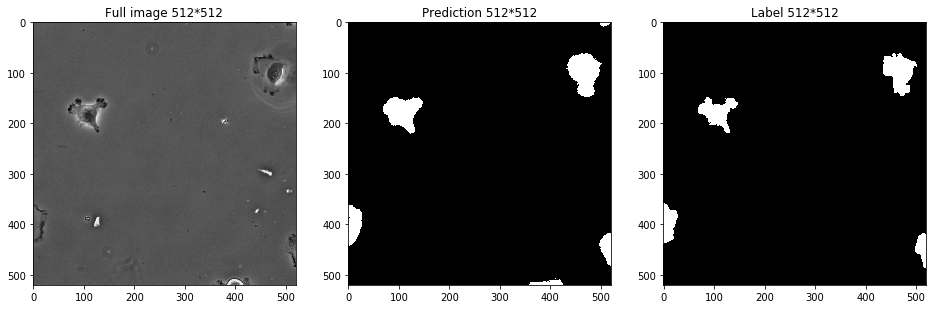

In [24]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    pad = int((image.shape[-1] - label.shape[-1]) / 2)

    ax0.imshow(image.detach(), cmap='gray')
    ax1.imshow(pred.detach(),  cmap='gray')
    ax2.imshow(label.detach(), cmap='gray')

    ax0.set_title('Full image 512*512')
    ax1.set_title('Prediction 512*512')
    ax2.set_title('Label 512*512')

## Results

In this last section of the notebook we report the results we obtained training and testing our network on the three different datasets, comparing them with the one reported in the paper.

### DIC-C2DH-HeLa

Here we report the results we obtain testing the network on the gold truth samples after the training on silver truth ones.

The result we obtain in term of IoU is 72.51% average and it is comparable with the result of 77.56% reported in the paper. Therefore we conclude this result is reproduced.

In [25]:
RESULTS1_HeLa = 'models/DIC-C2DH-HeLa/random_cropping_388/fold0/models/unet_weight_save_best_test'
RESULTS2_HeLa = 'models/DIC-C2DH-HeLa/random_cropping_388/fold2/models/unet_weight_save_best_test'
RESULTS3_HeLa = 'models/DIC-C2DH-HeLa/random_cropping_388/fold3/models/unet_weight_save_best_test'

In [26]:
test_iou1_HeLa = np.loadtxt(os.path.join(RESULTS1_HeLa, 'test_iou.out'))
test_iou2_HeLa = np.loadtxt(os.path.join(RESULTS2_HeLa, 'test_iou.out'))
test_iou3_HeLa = np.loadtxt(os.path.join(RESULTS3_HeLa, 'test_iou.out'))

iou_mean1_HeLa, iou_std1_HeLa = test_iou1_HeLa
iou_mean2_HeLa, iou_std2_HeLa = test_iou2_HeLa
iou_mean3_HeLa, iou_std3_HeLa = test_iou3_HeLa
iou_HeLa = [iou_mean1_HeLa, iou_mean2_HeLa, iou_mean3_HeLa]

paper_value_HeLa = 0.7756

In [27]:
data_HeLa = [round(iou_mean1_HeLa, 4), round(iou_mean2_HeLa, 4), round(iou_mean3_HeLa, 4), round(np.mean(iou_HeLa), 4), paper_value_HeLa]
names_HeLa = ['fold0', 'fold1', 'fold2', 'Average', 'Target']
metric_HeLa = ['IoU']

pandas.DataFrame(data_HeLa, names_HeLa, metric_HeLa)

IoU
fold0    0.7546
fold1    0.7298
fold2    0.6910
Average  0.7251
Target   0.7756

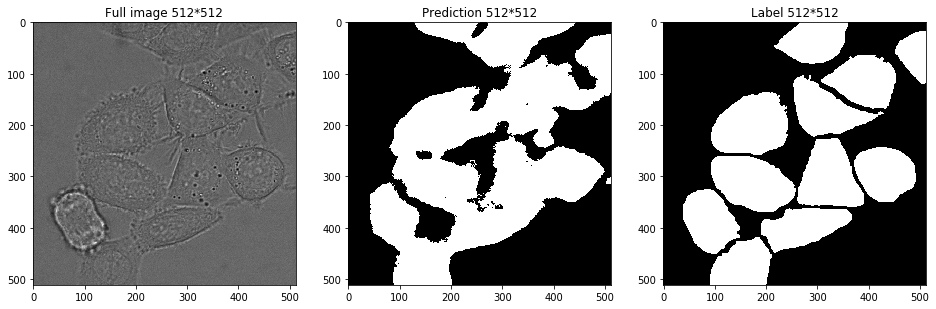

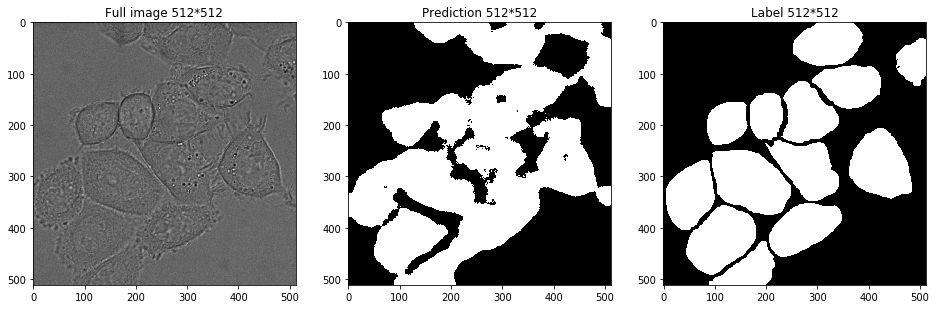

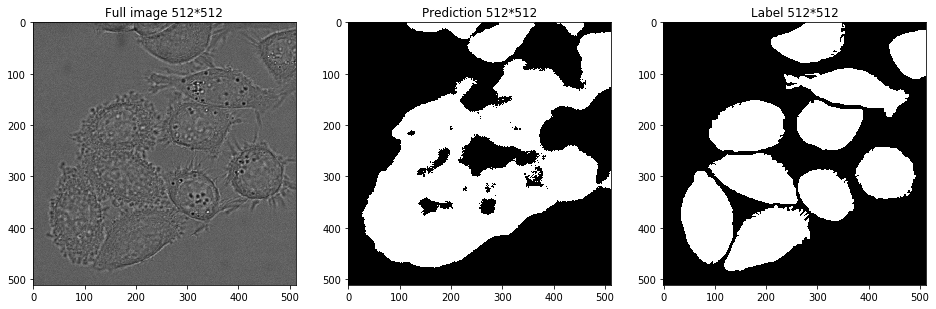

In [28]:
for i in range(3):
    image = cv.imread(os.path.join(RESULTS1_HeLa, 'images', f'image{i * 3}.tif'), -1)
    pred  = cv.imread(os.path.join(RESULTS1_HeLa, 'preds',  f'pred{i * 3}.tif'),  -1)
    label = cv.imread(os.path.join(RESULTS1_HeLa, 'labels', f'label{i * 3}.tif'), -1)

    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    pad = int((image.shape[-1] - label.shape[-1]) / 2)

    ax0.imshow(image, cmap='gray')
    ax1.imshow(pred,  cmap='gray')
    ax2.imshow(label, cmap='gray')

    ax0.set_title('Full image 512*512')
    ax1.set_title('Prediction 512*512')
    ax2.set_title('Label 512*512')

### ISBI2012

Using the ISBI2012 dataset, the results we obtained in term of pixel error are far away from the one obtained by the paper: 0.1995 in average against the target result of 0.0611.
In this case we conclude this result is not reproduced.

In [29]:
RESULTS1_ISBI = 'models/ISBI2012/rotation_388/fold0/models/unet_weight_save_best_test'
RESULTS2_ISBI = 'models/ISBI2012/rotation_388/fold1/models/unet_weight_save_best_test'
RESULTS3_ISBI = 'models/ISBI2012/rotation_388/fold2/models/unet_weight_save_best_test'

In [30]:
test_pe1_ISBI = np.loadtxt(os.path.join(RESULTS1_ISBI, 'test_pe.out'))
test_pe2_ISBI = np.loadtxt(os.path.join(RESULTS2_ISBI, 'test_pe.out'))
test_pe3_ISBI = np.loadtxt(os.path.join(RESULTS3_ISBI, 'test_pe.out'))

pe_mean1_ISBI, pe_std1_ISBI = test_pe1_ISBI
pe_mean2_ISBI, pe_std2_ISBI = test_pe2_ISBI
pe_mean3_ISBI, pe_std3_ISBI = test_pe3_ISBI
pe_ISBI = [pe_mean1_ISBI, pe_mean2_ISBI, pe_mean3_ISBI]

paper_value_ISBI = 0.0611

In [31]:
data_ISBI = [round(pe_mean1_ISBI, 4), round(pe_mean2_ISBI, 4), round(pe_mean3_ISBI, 4), round(np.mean(pe_ISBI), 4), paper_value_ISBI]
names_ISBI = ['fold0', 'fold1', 'fold2', 'Average', 'Target']
metric_ISBI = ['Pixel Error']

pandas.DataFrame(data_ISBI, names_ISBI, metric_ISBI)

Pixel Error
fold0         0.1963
fold1         0.2062
fold2         0.1962
Average       0.1995
Target        0.0611

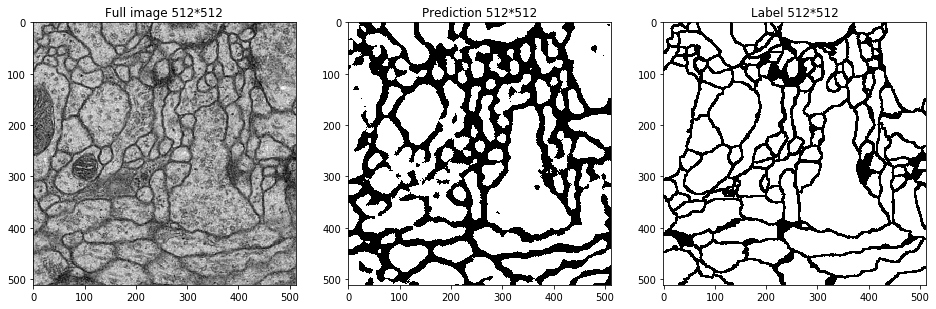

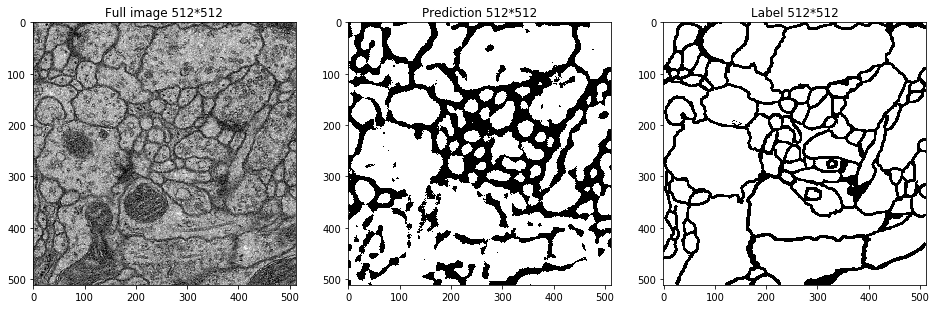

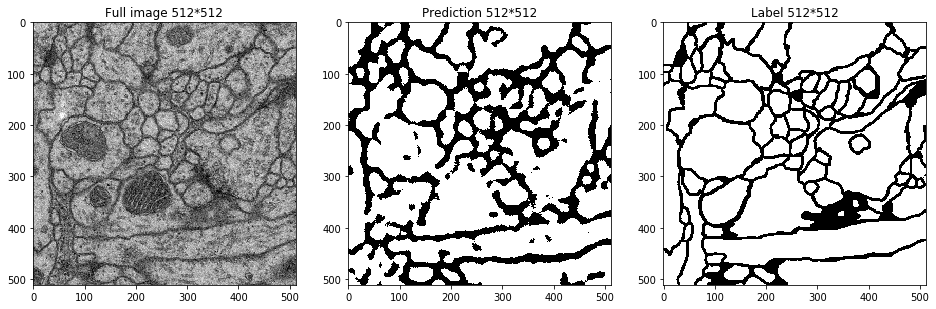

In [32]:
for i in range(3):
    image = cv.imread(os.path.join(RESULTS1_ISBI, 'images', f'image{i * 5}.tif'), -1)
    pred  = cv.imread(os.path.join(RESULTS1_ISBI, 'preds',  f'pred{i * 5}.tif'),  -1)
    label = cv.imread(os.path.join(RESULTS1_ISBI, 'labels', f'label{i * 5}.tif'), -1)

    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    pad = int((image.shape[-1] - label.shape[-1]) / 2)

    ax0.imshow(image, cmap='gray')
    ax1.imshow(pred,  cmap='gray')
    ax2.imshow(label, cmap='gray')

    ax0.set_title('Full image 512*512')
    ax1.set_title('Prediction 512*512')
    ax2.set_title('Label 512*512')

### PhC-C2DH-U373

Finally for the PhC dataset we obtain a quite good result of 68.74% IoU. However this is far away for the result of 92.03% the author of the paper obtained. 
We conclude this result is not reproduced.

In [33]:
RESULTS1_PhC = 'models/PhC-C2DH-U373/rotation_388/fold0/models/unet_weight_save_best_test'
RESULTS2_PhC = 'models/PhC-C2DH-U373/rotation_388/fold1/models/unet_weight_save_best_test'
RESULTS3_PhC = 'models/PhC-C2DH-U373/rotation_388/fold2/models/unet_weight_save_best_test'

In [34]:
test_iou1_PhC = np.loadtxt(os.path.join(RESULTS1_PhC, 'test_iou.out'))
test_iou2_PhC = np.loadtxt(os.path.join(RESULTS2_PhC, 'test_iou.out'))
test_iou3_PhC = np.loadtxt(os.path.join(RESULTS3_PhC, 'test_iou.out'))

iou_mean1_PhC, iou_std1_PhC = test_iou1_PhC
iou_mean2_PhC, iou_std2_PhC = test_iou2_PhC
iou_mean3_PhC, iou_std3_PhC = test_iou3_PhC
iou_PhC = [iou_mean1_PhC, iou_mean2_PhC, iou_mean3_PhC]

paper_value_PhC = 0.9203

In [35]:
data_PhC = [round(iou_mean1_PhC, 4), round(iou_mean2_PhC, 4), round(iou_mean3_PhC, 4), round(np.mean(iou_PhC), 4), paper_value_PhC]
names_PhC = ['fold0', 'fold1', 'fold2', 'Average', 'Target']
metric_PhC = ['IoU']

pandas.DataFrame(data_PhC, names_PhC, metric_PhC)

IoU
fold0    0.7052
fold1    0.6295
fold2    0.7276
Average  0.6874
Target   0.9203

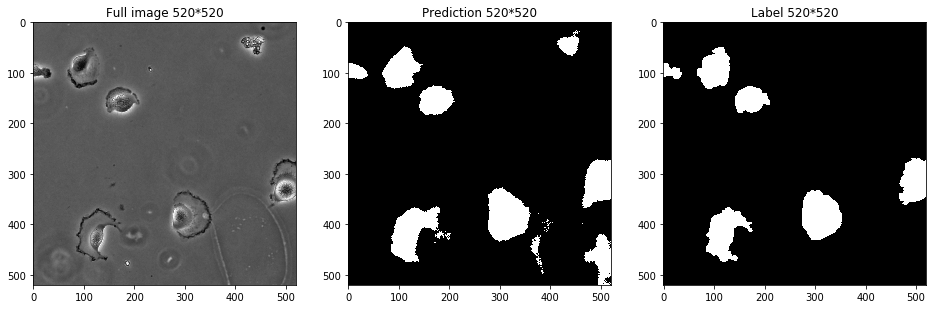

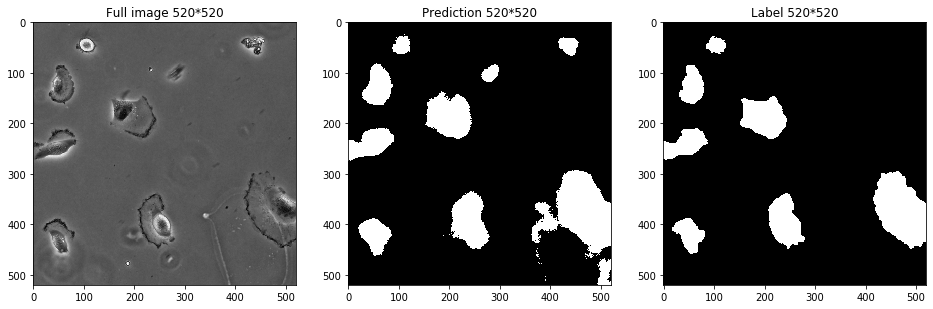

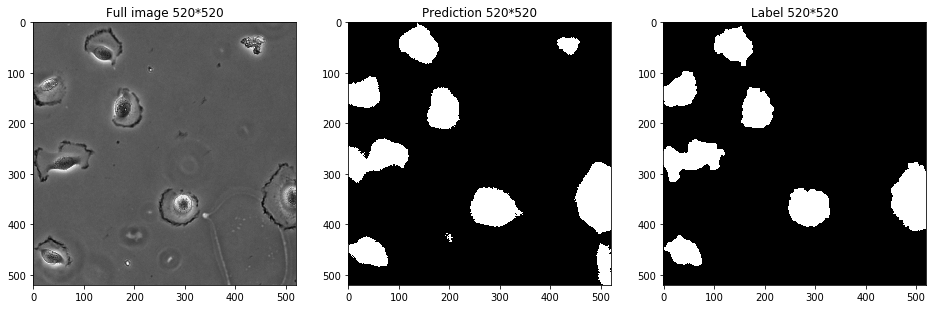

In [36]:
for i in range(3):
    image = cv.imread(os.path.join(RESULTS1_PhC, 'images', f'image{i * 5}.tif'), -1)
    pred  = cv.imread(os.path.join(RESULTS1_PhC, 'preds',  f'pred{i * 5}.tif'),  -1)
    label = cv.imread(os.path.join(RESULTS1_PhC, 'labels', f'label{i * 5}.tif'), -1)

    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    pad = int((image.shape[-1] - label.shape[-1]) / 2)

    ax0.imshow(image, cmap='gray')
    ax1.imshow(pred,  cmap='gray')
    ax2.imshow(label, cmap='gray')

    ax0.set_title('Full image 520*520')
    ax1.set_title('Prediction 520*520')
    ax2.set_title('Label 520*520')